# Bootstrapping Swap Curves

# 👉 <a id = "top">Table of Contents</a> 👈 

# [1. Helper Functions](#p1)

# [2. Bootstrap the OIS Discount Factor](#p2)
## [- BootStrapped OIS Discount Factors](#p2a)
## [- BootStrapped OIS Discount Curve](#p2b)

# [3. Bootstrap the LIBOR Discount Factor](#p3)
## [- BootStrapped LIBOR Discount Factors](#p3a)
## [- BootStrapped LIBOR Discount Curve](#p3b)

# [4. Forward swap rates](#p4)

# [5. Appendix](#p5)

In [8]:
import math
import numpy as np

import scipy.stats as si
from scipy.stats import norm

from scipy.optimize import fsolve
from scipy.optimize import brentq

from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import plotly.graph_objects as go
import pandas as pd
import datetime as dt

import warnings
warnings.filterwarnings('ignore') 

In [9]:
OIS_fixed_leg_frequency = 360

# <a id = "p1">1.</a>  <font color = "green"> Helper Functions </font>  [back to table of contents](#top)

In [10]:
def tenor_to_days_and_years_OIS(data: pd.DataFrame) -> pd.DataFrame:
    if "Tenor" not in data.columns:
        raise KeyError("Column 'Tenor' is missing from the DataFrame.")

    data["Tenor_Number"] = data["Tenor"].str[:-1].astype(int)
    data["Tenor_Unit"] = data["Tenor"].str[-1]

    data["Days"] = np.where(
        data["Tenor_Unit"] == "m", 
        data["Tenor_Number"] * 30,
        np.where(data["Tenor_Unit"] == "y", 
                 data["Tenor_Number"] * 360, 
                 np.nan)
    )

    data["Years"] = data["Days"] / 360

    data.drop(columns=["Tenor_Number", "Tenor_Unit"], inplace=True)

    years = [i for i in np.arange(1.0,30)]
    data[['f', 'OIS_Discount_Factor']] = np.nan
    data = data.merge(pd.DataFrame({"Years": years}),
                   how='outer')
    return data

# <a id = "p2">2.</a>  <font color = "green"> Bootstrap the OIS discount factor </font>  [back to table of contents](#top)

In [11]:
OIS_data = pd.read_excel("IR Data.xlsx",
                         sheet_name="OIS",
                         usecols="A:C")

tenors = OIS_data["Tenor"]

def tenor_to_years(tenor):
    if 'm' in tenor:
        return int(tenor.replace('m', '')) / 12
    elif 'y' in tenor:
        return int(tenor.replace('y', ''))
    else:
        return None

In [12]:
OIS_data = tenor_to_days_and_years_OIS(OIS_data)

### Setting Initial Short Rate \( f_0 \)

This code computes the **short-term instantaneous forward rate** \( f_0 \) for the given 6-month zero rate of 0.25%.

#### Formula:
$$
f_0 = 360 \left[ \left(1 + 0.5 \cdot r\right)^{\frac{1}{180}} - 1 \right]
$$

Where:
- \( r = 0.0025 \): 6-month zero rate (0.25%)
- \( 180 \): number of days in 6 months
- \( f_0 \): annualized short forward rate for the first day

This formula estimates the **instantaneous forward rate** implied by the compounded 6-month return, annualized on a 360-day basis.


In [13]:
f_0 = 360 * ((0.5*.0025+1)**(1/180)-1)
OIS_data.at[0,'f'] = f_0

### Calculating the First-Year Zero Rate and OIS Discount Factor

This snippet solves for the implied zero rate from 0.5 to 1 year by equating the present value (PV) of the fixed and floating legs of a 1-year payer OIS swap.

#### Explanation

- **Goal**: Solve for the implied zero rate \( f_1 \) for the period \( [0.5, 1] \) such that the PV of the fixed leg equals the PV of the floating leg.
- The function `payer_ois_swap_1y` defines the equation to be solved:
  $$
  \text{Fixed Leg} - \text{Floating Leg} = 0
  $$
- The floating leg value is computed from a known initial discount factor and swap conventions.
- The final line updates the OIS discount factor using the solved forward rate.

#### Formula

The full 1-year discount factor is calculated as:

$$
D(1) = \frac{1}{(1 + f_0/360)^{180} \cdot (1 + f_1/360)^{180}}
$$


In [14]:
def payer_ois_swap_1y(f_1, f_0, ois_1y):
    D_1 = 1/((1+f_0/360)**180 * (1+f_1/360)**180)

    fix_leg = D_1 * ois_1y
    flt_leg = D_1 * (1/D_1 - 1)

    return fix_leg - flt_leg
    
guess = 0.99

f_1 = fsolve(payer_ois_swap_1y, 
                         guess, 
                         args=(OIS_data.at[0, 'f'],
                               OIS_data.at[1, 'Rate']))[0]
OIS_data.at[1, 'f'] = f_1
OIS_data.at[1, 'OIS_Discount_Factor'] = 1/((1+f_0/360)**180 * (1+f_1/360)**180)

### Multi-Year OIS Discount Factor Calculation

This function computes the OIS discount factor \( D(t) \) for maturities beyond the first year, given a set of annual zero rates.

#### Explanation

- The total discount factor \( D(t) \) is constructed by chaining together annual discount factors for each year up to \( t \).
- The calculation starts with the first year's discount factor using:

  $$
  D_1 = \frac{1}{(1 + f_0/360)^{180} \cdot (1 + f_1/360)^{180}}
  $$

- For subsequent years \( i = 2, 3, $\dots$, t \), it multiplies the previous discount factor by the next year's annual discount factor:

  $$
  D_i = \frac{1}{(1 + f_i/360)^{360}}
  $$

- If the forward rate \( f_i \) is missing from the table, it defaults to the latest available forward rate \( f_t \).

#### Assumptions

- Day count convention is 360 days.
- Rates are compounded annually for years beyond 1.
- Forward rates are expressed in annual terms.


In [15]:
def D(t,df_ois, f_t):
    D = 1
    D *= 1/((1+df_ois.at[0,'f'] /360)**180 * (1+df_ois.at[1,'f']/360)**180)

    for i in range(2,int(t+1)):
        f_i = OIS_data.set_index('Years')['f'].get(i, f_t)
        if pd.isna(f_i):
            f_i = f_t
        D *= 1/((1+f_i/360)**360)
        
    return D

### Payer Swap PV (Year 2 Onward)

This function computes the present value (PV) of a payer interest rate swap **from year 2 onward**, using OIS discount factors and forward zero rates.

#### Explanation

- The function skips swaps with maturities less than 2 years.
- It calculates the PV of both the **fixed leg** and the **floating leg** and returns the difference.

#### Floating Leg (from Year 1 onward)

- The first year’s contribution is:

  $$
  D_1 = \frac{1}{(1 + f_0/360)^{180} \cdot (1 + f_1/360)^{180}}
  $$

- For each year \( i = 2 \) to \( T \):

  - The discount factor is:

    $$
    D_i = \prod_{j=2}^{i} \frac{1}{(1 + f_j / 360)^{360}}
    $$

  - The floating leg adds the term:

    $$
    D_i \cdot \left((1 + f_i / 360)^{360} - 1\right)
    $$

#### Fixed Leg

- The fixed leg is the product of:
  - The sum of all OIS discount factors up to year \( T \)
  - The annual fixed rate from the market

#### Return Value

- The final return is:

  $$
  \text{Swap PV} = \text{Float Leg} - \text{Fixed Leg}
  $$

#### Notes

- The function linearly interpolates missing forward rates.
- If a forward rate is not available, it defaults to the most recent one.


In [16]:
def payer_ois_swap_2y(f_n, df_ois, T):
    if T <2:
        return "only for 2 year onwards"
    fix_leg = 0
    flt_leg = 0
    cumsum_df = 0
    D1 = 1/((1+df_ois.at[0,'f'] /360)**180 * (1+df_ois.at[1,'f']/360)**180)
    flt_leg += D1 * (1/D1-1)
    cumsum_df += D1

    for i in range(2,int(T+1)):
        f_i = OIS_data.set_index('Years')['f'].get(i, f_n)
        if pd.isna(f_i):
            f_i = f_n
        Di = D(i,OIS_data,f_i)
        flt_leg +=  Di * ((1+f_i/360)**360-1)
        cumsum_df += Di
    
    fix_leg = cumsum_df * df_ois.loc[df_ois['Years']==i,'Rate'].values[0] 

    return flt_leg-fix_leg

### Bootstrapping OIS Zero Rates (Year 2 Onward)

This block performs iterative bootstrapping to derive forward zero rates from the second year onward using the `payer_ois_swap_2y` function.

#### Process Overview

1. **Initial Guess**:
   - A small initial guess for the forward rate is made:
     ```python
     guess = 0.0035
     ```

2. **Get Indices**:
   - `iter_idx` stores the indices of rows in `OIS_data` where the tenor exists (i.e., not missing), starting from the 3rd row onward:
     ```python
     iter_idx = OIS_data.loc[~OIS_data.Tenor.isna()].index[2:].values
     ```

3. **Iterative Solving**:
   - For each maturity:
     - Extract the maturity year \( T \)
     - Use `fsolve()` to find the forward rate \( f_i \) such that the PV of the swap (fixed leg - float leg) is zero:
       ```python
       f_i = fsolve(payer_ois_swap_2y, guess, args=(OIS_data, T))[0]
       ```

4. **Updating Data**:
   - The solved rate is updated into the dataframe:
     ```python
     OIS_data.at[i, 'f'] = f_i
     ```
   - Backfill is applied to fill in any missing forward rates for in-between tenors:
     ```python
     OIS_data['f'] = OIS_data['f'].bfill()
     ```

5. **Guess Update**:
   - The last solved forward rate is used as the guess for the next iteration.

6. **Special Handling**:
   - The discount factor for the 0.5 year point is filled manually:
     ```python
     OIS_data.at[0, 'OIS_Discount_Factor'] = 1 / (1 + f_0 / 360) ** 180
     ```

This completes the full bootstrapping process of the OIS zero curve from a list of par swap rates and their associated maturities.


In [17]:
guess = 0.0035
iter_idx = OIS_data.loc[~OIS_data.Tenor.isna()].index[2:].values

for i in iter_idx:
    T = OIS_data.loc[i,'Years']
    f_i = fsolve(payer_ois_swap_2y, 
                            guess, 
                            args=(OIS_data,
                                    T))[0]
    OIS_data.at[i, 'f'] = f_i
    OIS_data['f'] = OIS_data['f'].bfill()

    guess = f_i

OIS_data.at[0,'OIS_Discount_Factor'] = 1/(1+f_0/360)**180

# <a id = "p2a"></a>  <font color = "green">- BootStrapped OIS Discount Factors </font>  [back to table of contents](#top)

### Interpolating OIS Discount Factor Curve

This block computes and interpolates the OIS discount factor (`OIS_Discount_Factor`) curve on a semi-annual basis (every 0.5 years), even though the fixed leg of the OIS pays **annually**.

- Per-period discount factors are calculated using the zero rate (`f`) for both the 0.5-year and 1-year intervals.
- These are compounded cumulatively to obtain the full discount factor (`df`) at each tenor.
- The curve is extended onto a uniform 0.5-year grid from 0.5 to 30.5 years.
- Missing values between annual points are filled using **linear interpolation**.

Although fixed leg payments are annual, calculating the curve at 0.5-year intervals provides a **smoother curve** and facilitates more **detailed analysis** such as interpolation, plotting, and pricing instruments with non-standard maturities.


In [18]:
OIS_data.loc[:1, 'period_df'] = OIS_data[:2].apply(lambda row: 1 / ((1 + row['f'] / 360) ** (180)), axis=1)
OIS_data.loc[2:, 'period_df'] = OIS_data[2:].apply(lambda row: 1 / ((1 + row['f'] / 360) ** (360)), axis=1)
OIS_data['OIS_Discount_Factor'] =OIS_data['period_df'].cumprod()
OIS_data.drop(columns=['period_df'], inplace=True)

columns = ["Years", "Rate", "OIS_Discount_Factor"]
OIS_Interpolated_Data = OIS_data[columns].copy()

full_years = np.arange(0.5, 30.5, 0.5)

existing_years = set(OIS_Interpolated_Data["Years"])
missing_years = [year for year in full_years if year not in existing_years]

missing_df = pd.DataFrame({
    "Years": missing_years,
    "Rate": np.nan,
    "OIS_Discount_Factor": np.nan
})

OIS_Interpolated_Data = (
    pd.concat([OIS_Interpolated_Data, missing_df])
    .sort_values("Years")
    .interpolate(method="linear")
    .set_index("Years")
)

OIS_Interpolated_Data

,Rate,OIS_Discount_Factor
Years,,
0.5,0.002500,0.998752
1.0,0.003000,0.997009
1.5,0.003125,0.995270
2.0,0.003250,0.993531
2.5,0.003300,0.991773
3.0,0.003350,0.990015
3.5,0.003425,0.988066
4.0,0.003500,0.986117
4.5,0.003550,0.984150


# <a id = "p2b"></a>  <font color = "green">- BootStrapped OIS Discount Curve </font>  [back to table of contents](#top)

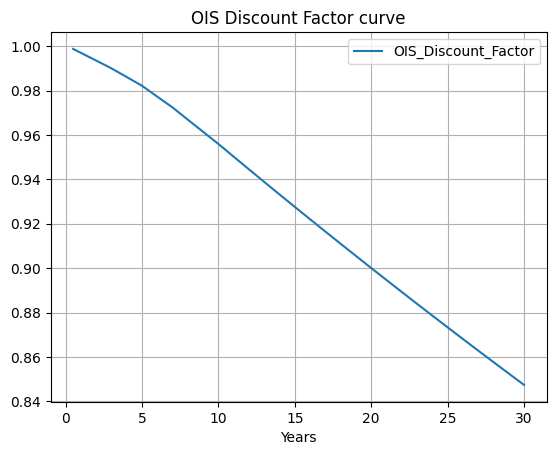

In [19]:
OIS_Interpolated_Data.reset_index(inplace=True)
OIS_Interpolated_Data.plot(x='Years',y='OIS_Discount_Factor')
plt.title("OIS Discount Factor curve")
plt.grid(True)
plt.show()

# <a id = "p3">3.</a>  <font color = "green"> Bootstrap the LIBOR discount factor </font>  [back to table of contents](#top)

In [20]:
IRS_data = pd.read_excel("IR Data.xlsx",
                        sheet_name="IRS",
                        usecols="A:C")

In [21]:
IRS_data["Years"] = [tenor_to_years(tenor) for tenor in tenors]
IRS_data = IRS_data.merge(OIS_data[['Years','f']],on='Years',how='outer')
IRS_data.rename(columns={"df": "ois_df"}, inplace=True)
years = [i for i in np.arange(1,30,.5)]
IRS_data = IRS_data.merge(pd.DataFrame({"Years": years}), how='outer')

IRS_data["f"] = IRS_data.f.bfill()
IRS_data['period_df'] = 1/(1+IRS_data['f']/360)**180
IRS_data['ois_df'] = IRS_data['period_df'].cumprod()
IRS_data.drop(columns=['period_df'],inplace=True)
IRS_data["libor_df"] = np.nan

### Payer IRS Swap Valuation Formula

The function computes the present value (PV) of a **payer interest rate swap**, which pays fixed and receives floating. The formula used is:

$$
\text{Swap PV} = \text{Floating Leg} - \text{Fixed Leg}
$$

---

#### **Fixed Leg Calculation**

Assumes fixed coupons are paid **semi-annually**, so the present value of the fixed leg is:

$$
\text{Fixed Leg} = 0.5 \cdot \text{Rate} \cdot \sum_{j=1}^{i} D_{\text{OIS}}(t_j)
$$

where:
- \( D_OIS(t_j) \) is the OIS discount factor at time \( t_j \)

---

#### **Floating Leg Calculation**

The floating leg uses the forward-looking formula:

$$
\text{Floating Leg} = D_0 \cdot \left( \frac{1 - D_1^{\text{LIBOR}}}{D_1^{\text{LIBOR}}} \right)
+ \sum_{j=2}^{i} D_j^{\text{OIS}} \cdot \left( \frac{D_{j-1}^{\text{LIBOR}} - D_j^{\text{LIBOR}}}{D_j^{\text{LIBOR}}} \right)
$$

This captures the present value of each expected floating payment under the assumption of **par swaps**.

---

#### **Interpolation & Gap Handling**

- Linear interpolation is used to fill in missing LIBOR discount factors for intermediate points (e.g., 1.5y, 2.5y, etc.).
- Including 0.5-year points ensures **smoothness in the discount curve** and more accurate **analytical sensitivity** or **risk management**.



In [22]:
def payer_irs_swap(df, i, irs):
    irs1 = irs.copy()
    irs1.at[i,'libor_df'] = df
    irs1[['Years','libor_df']] = irs1[['Years','libor_df']].interpolate(method='linear')

    cumsum_ois_df = irs1['ois_df'].iloc[:i+1].sum()
    irs_rate = irs1.at[i,'Rate']
    fix_leg = cumsum_ois_df * 0.5 * irs_rate

    float_leg = irs1.at[0,'ois_df'] * (1-irs1.at[0,'libor_df']) / irs1.at[0,'libor_df']
    for j in range(1,i+1):
        float_leg += irs1.at[j,'ois_df'] * (irs1.at[j-1,'libor_df']-irs1.at[j,'libor_df']) \
                                            / irs1.at[j,'libor_df']

    return float_leg - fix_leg

### Iterative Bootstrapping of the IRS Discount Curve

This section bootstraps the LIBOR (IRS) discount factors using the previously defined `payer_irs_swap` valuation function.

#### Iterative Solver

- Begins with the first LIBOR discount factor, computed directly as:

  $$
  D(0.5) = \frac{1}{1 + \frac{\text{Rate}}{2}}
  $$

- Then iteratively solves for each subsequent year's discount factor \( D(t) \), ensuring the present value of the fixed leg equals the present value of the floating leg:

  $$
  \text{PV}_{\text{float}}(t) = \text{PV}_{\text{fixed}}(t)
  $$

- The unknown discount factor is solved using `fsolve`, and the previous solution is reused as the initial guess to improve convergence. This is especially important due to the presence of multiple roots.


In [23]:
IRS_data.at[0,'libor_df'] = 1/(1+IRS_data.at[0,'Rate']/2)
idx_irs = IRS_data[IRS_data['Product'] == "IRS"].index[1:]
guess = .99

for i in idx_irs:
        x = fsolve(payer_irs_swap,
                    guess,
                    args=(i,IRS_data))[0]
        IRS_data.at[i, 'libor_df'] = x
        guess = x
IRS_data['libor_df'] = IRS_data['libor_df'].interpolate(method='linear')

In [24]:
clean_columns = ['Years', 'Rate', 'ois_df', 'libor_df']
IRS_cleaned = IRS_data[clean_columns].copy()

IRS_cleaned.rename(columns={
    'ois_df': 'OIS_Discount_Factor',
    'libor_df': 'IRS_Discount_Factor'
}, inplace=True)

IRS_cleaned = IRS_cleaned.set_index('Years')
IRS_cleaned = IRS_cleaned.sort_index()
IRS_cleaned = IRS_cleaned.interpolate(method='linear')

# <a id = "p3a"></a>  <font color = "green">- BootStrapped LIBOR Discount Factors </font>  [back to table of contents](#top)

In [25]:
IRS_cleaned["Forward_LIBOR"] = np.nan

IRS_cleaned.at[IRS_cleaned.index[0], "Forward_LIBOR"] = IRS_cleaned.at[IRS_cleaned.index[0], "Rate"]

for row in range(1, len(IRS_cleaned)):
    rate_now = IRS_cleaned.at[IRS_cleaned.index[row], "Rate"]
    rate_prev = IRS_cleaned.at[IRS_cleaned.index[row - 1], "Rate"]
    
    t_now = IRS_cleaned.index[row]
    t_prev = IRS_cleaned.index[row - 1]
    
    forward_rate = (
        (1 + rate_now / 2) ** (2 * t_now) /
        (1 + rate_prev / 2) ** (2 * t_prev)
    ) ** 2 - 1
    
    IRS_cleaned.at[IRS_cleaned.index[row], "Forward_LIBOR"] = forward_rate
IRS_cleaned

,Rate,OIS_Discount_Factor,IRS_Discount_Factor,Forward_LIBOR
Years,,,,
0.5,0.025000,0.998752,0.987654,0.025000
1.0,0.028000,0.997009,0.972496,0.031245
1.5,0.029000,0.995268,0.957338,0.031242
2.0,0.030000,0.993531,0.942179,0.033275
2.5,0.030750,0.991771,0.926330,0.034038
3.0,0.031500,0.990015,0.910482,0.035565
3.5,0.032000,0.988064,0.894731,0.035309
4.0,0.032500,0.986117,0.878981,0.036328
4.5,0.032750,0.984148,0.863985,0.035053


# <a id = "p3b"></a>  <font color = "green">- BootStrapped LIBOR Discount Curve </font>  [back to table of contents](#top)

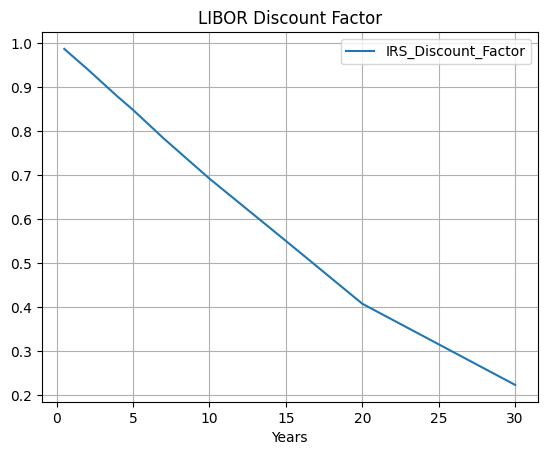

In [26]:
IRS_cleaned.reset_index(inplace=True)
IRS_cleaned.plot(x='Years',y='IRS_Discount_Factor')
plt.title("LIBOR Discount Factor")
plt.grid(True)
plt.show()

# <a id = "p4">4.</a>  <font color = "green"> Forward swap rates </font>  [back to table of contents](#top)

### Valuation of Forward Payer IRS Swap

This forward swap valuation function computes the value of a payer interest rate swap starting in the future, specifically at time \( t = \text{start} \), with a tenor of \( \text{tenor} \) years.

---

#### Fixed Leg Calculation

The present value of the fixed leg is calculated using:

$$
\text{PV}_{\text{fixed}} = \left( \sum_{t = \text{start}}^{\text{start} + \text{tenor}} D(0, t) \right) \cdot 0.5 \cdot \text{Forward Swap Rate}
$$

The summation term includes the OIS discount factors for each payment date, with the payments assumed to be made semi-annually (hence the factor \( 0.5 \)).

To correctly value a forward-starting swap, the fixed leg’s value is calculated by taking the sum of all discount factors from \( \text{start} \) to \( \text{start} + \text{tenor} \), and **subtracting** the sum of discount factors up to \( \text{start} \), so that only the forward period is considered.

---

#### Floating Leg Calculation

The floating leg replicates a sequence of forward rate payments and is valued as:

$$
\text{PV}_{\text{float}} = \sum_{j=1}^{N} D(0, t_j) \cdot \frac{D(0, t_{j-1}) - D(0, t_j)}{D(0, t_j)}
$$

This expression reflects the value of the forward floating cash flows between each coupon date \( t_{j-1} \) and \( t_j \), using the IRS discount factors.

The floating leg is also computed only for the forward-starting interval.

---

#### Valuation Output

The net value of the forward payer swap is:

$$
\text{Value} = \text{PV}_{\text{fixed}} - \text{PV}_{\text{float}}
$$

This can be used for pricing, trading, or identifying arbitrage in forward IRS contracts.


In [27]:
def payer_irs_fwd_swap(fwd_swap_rate, start=1, tenor=1, irs=IRS_cleaned):
    cumsum_ois_df = irs.loc[irs['Years'] <= start+tenor, 'OIS_Discount_Factor'].sum() \
                        - irs.loc[irs['Years'] <= start, 'OIS_Discount_Factor'].sum()
    fix_leg = cumsum_ois_df * 0.5 * fwd_swap_rate

    float_leg = 0
    for j in range(int(start*2),int((start+tenor)*2)):
        float_leg += irs.at[j,'OIS_Discount_Factor'] * (irs.at[j-1,'IRS_Discount_Factor']-irs.at[j,'IRS_Discount_Factor']) \
                                            / irs.at[j,'IRS_Discount_Factor']

    return fix_leg - float_leg

### Forward Swap Rate Table Construction and Solver

A DataFrame `fsr` is constructed to represent a grid of forward-starting interest rate swaps, each defined by a pair of:

- **Start time** \( s \)
- **Tenor** \( T \)

This defines a swap contract that begins at time \( s \) and ends at \( s + T \).

For each forward-starting period, we solve for the forward swap rate \( $R^{\text{fwd}}$ \) using the condition that the present value of the payer swap must be zero:

$$
\text{PV}_{\text{fixed}}(R^{\text{fwd}}) = \text{PV}_{\text{floating}}
$$

That is, we solve:

$$
\left( \sum_{t=s+1}^{s+T} D(0, t) \right) \cdot 0.5 \cdot R^{\text{fwd}} = \sum_{j=1}^{N} D(0, t_j) \cdot \frac{D(0, t_{j-1}) - D(0, t_j)}{D(0, t_j)}
$$

Here:
- \( D(0, t) \) represents the OIS discount factor.
- The fixed leg uses semi-annual payments (hence the 0.5 factor).
- The floating leg mimics the value of a series of forward Libor payments.

The `fsolve` function is used to numerically compute the forward rate \( $R^{\text{fwd}}$ \) that equates the fixed and floating legs of the forward-starting swap.


In [28]:
fsr = pd.DataFrame({'start' : [1]*5 + [5]*5 + [10]*5,
                          'tenor' : [1,2,3,5,10]*3, 
                          'Forward_Swap_Rates': [np.nan]*15
                   })
                    # 'f_ois': [np.nan]*15})

for idx, row in fsr.iterrows():
    start = row['start']
    tenor = row['tenor']
    ois_day_frac = 1
    L = 1

    fsr.at[idx, 'Forward_Swap_Rates'] = fsolve(payer_irs_fwd_swap,
                                      guess,
                                      args=(start,
                                            tenor,
                                            IRS_cleaned))
    
    # compute forward OIS
    # num = OIS_data.loc[OIS_data.Years==start]['OIS_Discount_Factor'].values[0] - OIS_data.loc[OIS_data.Years==start+tenor]['OIS_Discount_Factor'].values[0]
    # den = ois_day_frac * (OIS_data.loc[OIS_data.Years<=start+tenor]['OIS_Discount_Factor'].sum() - OIS_data.loc[OIS_data.Years<=start]['OIS_Discount_Factor'].sum())
    # fsr.at[idx, 'f_ois'] = num/den

fsr

,start,tenor,Forward_Swap_Rates
0,1,1,0.031922
1,1,2,0.033217
2,1,3,0.033982
3,1,5,0.035238
4,1,10,0.038419
5,5,1,0.039274
6,5,2,0.040075
7,5,3,0.040072
8,5,5,0.041093
9,5,10,0.043634


In [29]:
fsr.to_csv("Forward_swap_rates_df.csv",index=False)

In [30]:
IRS_cleaned.to_csv("Discount_Factors.csv",index=False)

# <a id = "p5">5.</a>  <font color = "green"> Appendix </font>  [back to table of contents](#top)

This section demonstrates that the problem can be approached using an alternative method, yielding results that are very close to those obtained through the approach outlined in the project notes.

## Helper Functions

In [31]:
def plot_discount_curve(df: pd.DataFrame,
                        discount_curve: str,
                        title: str):
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df.index, 
        y=df[discount_curve], 
        mode='lines+markers',
        name="Discount Curve",
        line=dict(width=2), 
        marker=dict(size=6)
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Tenor (years)",
        yaxis_title="Discount Factor",
        template="plotly_white",
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )

    fig.show()

In [32]:
def tenor_to_days_and_years(data: pd.DataFrame) -> pd.DataFrame:
    if "Tenor" not in data.columns:
        raise KeyError("Column 'Tenor' is missing from the DataFrame.")

    data["Tenor_Number"] = data["Tenor"].str[:-1].astype(int)
    data["Tenor_Unit"] = data["Tenor"].str[-1]

    data["Days"] = np.where(
        data["Tenor_Unit"] == "m", 
        data["Tenor_Number"] * 30,
        np.where(data["Tenor_Unit"] == "y", 
                 data["Tenor_Number"] * 360, 
                 np.nan)
    )

    data["Years"] = data["Days"] / 360

    data.drop(columns=["Tenor_Number", "Tenor_Unit"], inplace=True)
    return data

In [33]:
def plot_discount_curve(df: pd.DataFrame,
                        discount_curve: str,
                        title: str):
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df.index, 
        y=df[discount_curve], 
        mode='lines+markers',
        name="Discount Curve",
        line=dict(width=2), 
        marker=dict(size=6)
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Tenor (years)",
        yaxis_title="Discount Factor",
        template="plotly_white",
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )

    fig.show()

## Bootstrap the OIS Discount Factor

In [34]:
OIS_data_appendix = pd.read_excel("IR Data.xlsx",
                         sheet_name="OIS",
                         usecols="A:C")

In [35]:
tenor_to_days_and_years(OIS_data_appendix)

,Tenor,Product,Rate,Days,Years
0,6m,OIS,0.00250,180.0,0.5
1,1y,OIS,0.00300,360.0,1.0
2,2y,OIS,0.00325,720.0,2.0
3,3y,OIS,0.00335,1080.0,3.0
4,4y,OIS,0.00350,1440.0,4.0
5,5y,OIS,0.00360,1800.0,5.0
6,7y,OIS,0.00400,2520.0,7.0
7,10y,OIS,0.00450,3600.0,10.0
8,15y,OIS,0.00500,5400.0,15.0
9,20y,OIS,0.00525,7200.0,20.0


### Short Tenor OIS Discount Factor

For short maturities ≤ 1Y, the discount factor is calculated using the 30/360 day count convention:

$$
DF = \frac{1}{1 + \left( \frac{\text{days}}{360} \right) \cdot r}
$$

Where:
- \(days\): Tenor in days.
- \(r\): OIS annualized rate (in decimals, e.g. 0.003 for 0.3%).


In [36]:
def handle_short_tenor(row, data, OIS_fixed_leg_frequency):
    days = data.at[row, "Days"]
    years = data.at[row, "Years"]
    rate = data.at[row, "Rate"]

    df = 1 / (1 + (days / 360) * rate)
    data.at[row, "OIS_Discount_Factor"] = df

    if years >= OIS_fixed_leg_frequency / 360:
        data.at[row, "Sum_Discount_Factor"] = df

    return data

###  Long Tenor OIS Discount Factor

For tenors longer than one fixed leg period, the OIS discount factor is computed by solving the swap pricing condition:

$$
DF_n = \frac{1 - r \cdot \text{SumDF}_{n-1} - \text{gap} \cdot 0.5 \cdot r \cdot DF_{n-1}}{1 + (1 + \text{gap} \cdot 0.5) \cdot r}
$$

Where:
- \( DF_n \): Current discount factor.
- \( DF_n-1 \): Previous discount factor.
- \( SumDF_n-1\): Cumulative sum of discount factors before year \( n \).
- \(r\): Annualized OIS rate (in decimals).
- \( gap = t_n - t_n-1 - 1 \): Years between the previous and current tenor, minus the first year already handled separately.

This formula ensures that the present value of fixed and floating legs remains equal when bootstrapping over long maturities.

In [37]:
def calculate_long_discount_factor(rate, prev_sum_df, prev_years, current_years, prev_df):
    gap = current_years - prev_years - 1
    numerator = 1 - rate * prev_sum_df - gap * 0.5 * rate * prev_df
    denominator = 1 + (1 + gap * 0.5) * rate
    return numerator / denominator

### First Year Sum of Discount Factors

This function updates the cumulative sum of discount factors when the current tenor is **exactly one year beyond** the previous tenor.

$$
\text{SumDF}_n = (t_n - t_{n-1}) \cdot DF_n + \text{SumDF}_{n-1}
$$

Where:
- \( SumDF_n \): New cumulative sum of discount factors.
- \( DF_n \): Current discount factor.
- \( SumDF_n-1 \): Previous cumulative sum.
- \( t_n - t_n-1 \): Time interval in years (typically 1 here).

Used during OIS bootstrapping when there is no need to interpolate between discount factors (i.e. simple year-on-year accumulation).

In [38]:
def sum_df_first_year(years, prev_years, current_df, prev_sum_df):
    return (years - prev_years) * current_df + prev_sum_df

### Trapezoidal Sum of Discount Factors

This function updates the cumulative sum of discount factors when the time interval between two tenors is **greater than one year**, requiring interpolation using the trapezoidal rule.

$$
\text{SumDF}_n = (t_n - t_{n-1} - 1) \cdot \frac{DF_{n-1} + DF_n}{2} + DF_{n-1} + \text{SumDF}_{n-1}
$$

Where:
- \( SumDF_n \): New cumulative sum of discount factors.
- \( DF_n-1 \), \( DF_n \): Previous and current discount factors.
- \( t_n - t_n-1 \): Time difference in years between current and previous tenors.
- The `− 1` accounts for the first year already included in a prior term.

Used during OIS bootstrapping when interpolating between annual fixed leg payments over multi-year tenors.

In [39]:
def sum_df_trapezoidal(years, prev_years, prev_df, current_df, prev_sum_df):
    delta_years = years - prev_years + 1
    average_df = (prev_df + current_df) / 2
    return delta_years * average_df - prev_df + prev_sum_df

### Long Tenor Handler for OIS Bootstrapping

This function computes the discount factor and cumulative sum of discount factors for OIS instruments with tenors **greater than 1 year**.

---

#### Step 1: Compute the Discount Factor

The long-tenor discount factor is derived from the swap pricing condition:

$$
DF_n = \frac{1 - r \cdot \text{SumDF}_{n-1} - \text{gap} \cdot 0.5 \cdot r \cdot DF_{n-1}}{1 + (1 + \text{gap} \cdot 0.5) \cdot r}
$$

Where:
- \( DF_n \): Current discount factor.
- \( DF_{n-1} \): Previous discount factor.
- \( SumDF_n-1 \): Previous cumulative sum.
- \( r \): OIS rate.
- \( gap = t_n - t_n-1 - 1 \): Number of years beyond the first.

---

#### Step 2: Compute the Sum of Discount Factors

- If \( t_n - t_n-1 = 1 \): Use direct accumulation:

$$
\text{SumDF}_n = (t_n - t_{n-1}) \cdot DF_n + \text{SumDF}_{n-1}
$$

- Else (tenor spans multiple years): Use trapezoidal integration:

$$
\text{SumDF}_n = (t_n - t_{n-1} - 1) \cdot \frac{DF_n + DF_{n-1}}{2} + DF_{n-1} + \text{SumDF}_{n-1}
$$

---

This modular design allows for accurate and flexible OIS curve construction using a mix of exact and interpolated values.

In [40]:
def handle_long_tenor(row, data):
    years = data.at[row, "Years"]
    prev_years = data.at[row - 1, "Years"]
    rate = data.at[row, "Rate"]
    prev_df = data.at[row - 1, "OIS_Discount_Factor"]
    prev_sum_df = data.at[row - 1, "Sum_Discount_Factor"]

    df = calculate_long_discount_factor(rate, prev_sum_df, prev_years, years, prev_df)
    data.at[row, "OIS_Discount_Factor"] = df

    if (years - prev_years) == 1:
        sum_df = sum_df_first_year(years, prev_years, df, prev_sum_df)
    else:
        sum_df = sum_df_trapezoidal(years, prev_years, prev_df, df, prev_sum_df)

    data.at[row, "Sum_Discount_Factor"] = sum_df

    return data

### OIS Bootstrapping Loop

This loop constructs the OIS discount curve by iterating over each tenor in the data:

1. **Short-tenor logic** (first row or ≤ 1 fixed-leg period):
   - Uses the short tenor formula:

    $$
   DF = \frac{1}{1 + \left( \frac{\text{days}}{360} \right) \cdot r}
   $$
   - Applied via `handle_short_tenor`.

4. **Long-tenor logic** (tenor > 1Y):
   - Bootstraps the OIS discount factor using swap pricing logic and prior terms.
   - Applied via `handle_long_tenor`.

Both discount factors and their cumulative sums are computed and stored:

- `"OIS_Discount_Factor"`: Present value at the given maturity.
- `"Sum_Discount_Factor"`: Aggregated value used for pricing longer swaps.

In [41]:
OIS_data_appendix["OIS_Discount_Factor"] = np.nan
OIS_data_appendix["Sum_Discount_Factor"] = np.nan

for row in range(len(OIS_data_appendix)):
    days = OIS_data_appendix.at[row, "Days"]
    if row == 0 or days <= OIS_fixed_leg_frequency:
        OIS_data_appendix = handle_short_tenor(row, OIS_data_appendix, OIS_fixed_leg_frequency)
    else:
        OIS_data_appendix = handle_long_tenor(row, OIS_data_appendix)
OIS_data_appendix

,Tenor,Product,Rate,Days,Years,OIS_Discount_Factor,Sum_Discount_Factor
0,6m,OIS,0.00250,180.0,0.5,0.998752,NaN
1,1y,OIS,0.00300,360.0,1.0,0.997009,0.997009
2,2y,OIS,0.00325,720.0,2.0,0.993531,1.990540
3,3y,OIS,0.00335,1080.0,3.0,0.990015,2.980555
4,4y,OIS,0.00350,1440.0,4.0,0.986117,3.966672
5,5y,OIS,0.00360,1800.0,5.0,0.982184,4.948856
6,7y,OIS,0.00400,2520.0,7.0,0.972406,6.898556
7,10y,OIS,0.00450,3600.0,10.0,0.955977,9.782916
8,15y,OIS,0.00500,5400.0,15.0,0.927611,14.477704
9,20y,OIS,0.00525,7200.0,20.0,0.900076,19.033155


### OIS Discount Factor Interpolation

This section fills in missing discount factors on a **0.5-year grid** by linearly interpolating between known maturities.

---

#### Steps:

1. **Subset Columns**: Keep only `"Years"`, `"Rate"`, and `"OIS_Discount_Factor"` for interpolation.

2. **Define Grid**: Create a regularly spaced sequence:
   $$
   \text{full\_years} = [0.5, 1.0, 1.5, \dots, 30.0]
   $$

3. **Identify Gaps**: Compare existing maturities with the full grid to find missing time points.

4. **Create Dummy Rows**: Add NaN-filled rows for the missing maturities.

5. **Combine and Interpolate**:
   - Concatenate real and dummy data.
   - Sort by `"Years"`.
   - Interpolate linearly over the missing values:
     $$
     DF(t) = DF(t_1) + \frac{t - t_1}{t_2 - t_1} \cdot (DF(t_2) - DF(t_1))
     $$

---


In [42]:
columns = ["Years", "Rate", "OIS_Discount_Factor"]
OIS_Interpolated_Data = OIS_data_appendix[columns].copy()
full_years = np.arange(0.5, 30.5, 0.5)

existing_years = set(OIS_Interpolated_Data["Years"])
missing_years = [year for year in full_years if year not in existing_years]

missing_df = pd.DataFrame({
    "Years": missing_years,
    "Rate": np.nan,
    "OIS_Discount_Factor": np.nan
})

OIS_Interpolated_Data = (
    pd.concat([OIS_Interpolated_Data, missing_df])
    .sort_values("Years")
    .interpolate(method="linear")
    .set_index("Years")
)

In [43]:
OIS_Interpolated_Data

,Rate,OIS_Discount_Factor
Years,,
0.5,0.002500,0.998752
1.0,0.003000,0.997009
1.5,0.003125,0.995270
2.0,0.003250,0.993531
2.5,0.003300,0.991773
3.0,0.003350,0.990015
3.5,0.003425,0.988066
4.0,0.003500,0.986117
4.5,0.003550,0.984150


In [44]:
plot_discount_curve(df=OIS_Interpolated_Data,
                    discount_curve="OIS_Discount_Factor",
                    title="OIS Discount Curve")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Bootstrap the LIBOR Discount Factor

In [ ]:
IRS_data_appendix = pd.read_excel("IR Data.xlsx",
                        sheet_name="IRS",
                        usecols="A:C")

In [ ]:
convert_tenor = tenor_to_days_and_years(IRS_data_appendix)

### IRS Data Preparation for Bootstrapping

This block prepares the IRS curve for bootstrapping by ensuring a uniform 0.5-year tenor spacing and integrating OIS discount factors.

---

#### Steps:

1. **Extract Required Columns**  
   Only `"Years"` and `"Rate"` are retained from the IRS dataset for interpolation.

2. **Build 0.5-Year Grid**  
   Create the full sequence:
   $$
   \text{full\_years} = [0.5, 1.0, 1.5, \dots, 30.0]
   $$

3. **Identify Missing Tenors**  
   Compare the full timeline with existing maturities to find gaps.

4. **Add Missing Tenors**  
   Fill missing time points with rows containing:
   - `"Years"` = missing year
   - `"Rate"` = `NaN` (to be interpolated)

5. **Combine and Interpolate**  
   Merge existing and dummy rows, then sort and reindex:
   $$
   \text{IRS\_Interpolated\_Data} = \text{IRS\_Data} \cup \text{Missing Rows}
   $$

6. **Inject OIS Discount Factors**  
   Copy OIS discount factors into this frame for later forward LIBOR and IRS bootstrapping.

7. **Initialize IRS Discount Factor Column**  
   Set up an empty `"IRS_Discount_Factor"` column with `NaN` values to be computed next.

---

This process prepares a clean IRS structure for curve building, aligning it with OIS data and enabling seamless forward and spot rate derivation.


In [ ]:
IRS_Interpolated_Data = IRS_data_appendix[["Years", "Rate"]].copy()

full_years = np.arange(0.5, 30.5, 0.5)
existing_years = set(IRS_Interpolated_Data["Years"])
missing_years = [year for year in full_years if year not in existing_years]

missing_df = pd.DataFrame({
    "Years": missing_years,
    "Rate": [np.nan] * len(missing_years)
})

IRS_Interpolated_Data = pd.concat([IRS_Interpolated_Data, missing_df])
IRS_Interpolated_Data = IRS_Interpolated_Data.sort_values("Years").set_index("Years")

IRS_Interpolated_Data["OIS_Discount_Factor"] = OIS_Interpolated_Data["OIS_Discount_Factor"]

IRS_Interpolated_Data["IRS_Discount_Factor"] = np.nan

IRS_Interpolated_Data = IRS_Interpolated_Data.reset_index(names="Years")

## IRS Bootstrapping using Brent's Method

Bootstrap the **IRS (Interest Rate Swap) discount factor curve** using the OIS discount curve as input, solving for the fixed leg present value such that it equals the floating leg present value.

---

### Core Logic

For each swap maturity:

1. **Define Equation**  
   The present value of the fixed leg:

   $$
   PV_{\text{fixed}} = \sum_{j=1}^{n} \frac{\text{OIS\_DF}_j}{\text{IRS\_DF}_j} \cdot 2
   $$

   is equated to the floating leg approximation:

   $$
   PV_{\text{float}} = \text{Rate}_n + 2 \cdot \sum_{j=1}^{n} \text{OIS\_DF}_j
   $$

2. **Solve for Discount Factor**  
   We solve the equation:

   $$
   f(\text{DF}) = PV_{\text{fixed}} - PV_{\text{float}} = 0
   $$

   using Brent’s root-finding method (`scipy.optimize.brentq`).

3. **Update IRS Discount Factor**  
   The solved value is stored in the `"IRS_Discount_Factor"` column.

---

### Why Brent’s Method?

Brent’s method is used for solving nonlinear equations with a guaranteed root in a given interval. It’s suitable here because the discount factor must lie between 0 and 1.

---


In [ ]:
index = IRS_Interpolated_Data[pd.notna(IRS_Interpolated_Data['Rate'])].index

for i in index:
    def equation1(df, i = i):
        irs = IRS_Interpolated_Data.iloc[0:i+1].copy()
        irs['IRS_Discount_Factor'].iloc[-1] = df
        irs[['Years', 'IRS_Discount_Factor']] = irs[['Years', 'IRS_Discount_Factor']].interpolate(method='linear')
        sum = 0
        for i in range(len(irs)):
            if i == 0:
                sum += irs["OIS_Discount_Factor"].iloc[i]/irs['IRS_Discount_Factor'].iloc[i]*2
            else:
                sum += irs["OIS_Discount_Factor"].iloc[i]*irs['IRS_Discount_Factor'].iloc[i-1]/irs['IRS_Discount_Factor'].iloc[i]*2
    
        return sum - (irs['Rate'].iloc[-1] + 2)*np.sum(irs['OIS_Discount_Factor'])

    IRS_Interpolated_Data.at[i, 'IRS_Discount_Factor'] = brentq(equation1, 0.001, 1)

IRS_Interpolated_Data = IRS_Interpolated_Data.interpolate(method='linear')
IRS_Interpolated_Data.set_index("Years",inplace=True)

## Calculating Forward LIBOR from Spot Rates

This section calculates the **Forward LIBOR** from the spot rates using the following relationship:

For tenor \( T_n \), the forward rate between \( T_{n-1} \) and \( T_n \) is computed as:

$$
\text{Forward}_{n} = \left( \frac{(1 + r_n / 2)^{2 T_n}}{(1 + r_{n-1} / 2)^{2 T_{n-1}}} \right)^2 - 1
$$

Where:
- \( r_n \): Spot rate at year \( T_n \)
- \( r_{n-1} \): Spot rate at year \( T_{n-1} \)


---


In [ ]:
IRS_Interpolated_Data["Forward_LIBOR"] = np.nan

IRS_Interpolated_Data.at[IRS_Interpolated_Data.index[0], "Forward_LIBOR"] = IRS_Interpolated_Data.at[IRS_Interpolated_Data.index[0], "Rate"]

for row in range(1, len(IRS_Interpolated_Data)):
    rate_now = IRS_Interpolated_Data.at[IRS_Interpolated_Data.index[row], "Rate"]
    rate_prev = IRS_Interpolated_Data.at[IRS_Interpolated_Data.index[row - 1], "Rate"]
    
    t_now = IRS_Interpolated_Data.index[row]
    t_prev = IRS_Interpolated_Data.index[row - 1]
    
    forward_rate = (
        (1 + rate_now / 2) ** (2 * t_now) /
        (1 + rate_prev / 2) ** (2 * t_prev)
    ) ** 2 - 1
    
    IRS_Interpolated_Data.at[IRS_Interpolated_Data.index[row], "Forward_LIBOR"] = forward_rate


In [ ]:
IRS_Interpolated_Data

,Rate,OIS_Discount_Factor,IRS_Discount_Factor,Forward_LIBOR
Years,,,,
0.5,0.025000,0.998752,0.987654,0.025000
1.0,0.028000,0.997009,0.972577,0.031245
1.5,0.029000,0.995270,0.957378,0.031242
2.0,0.030000,0.993531,0.942179,0.033275
2.5,0.030750,0.991773,0.926330,0.034038
3.0,0.031500,0.990015,0.910482,0.035565
3.5,0.032000,0.988066,0.894731,0.035309
4.0,0.032500,0.986117,0.878981,0.036328
4.5,0.032750,0.984150,0.863985,0.035053


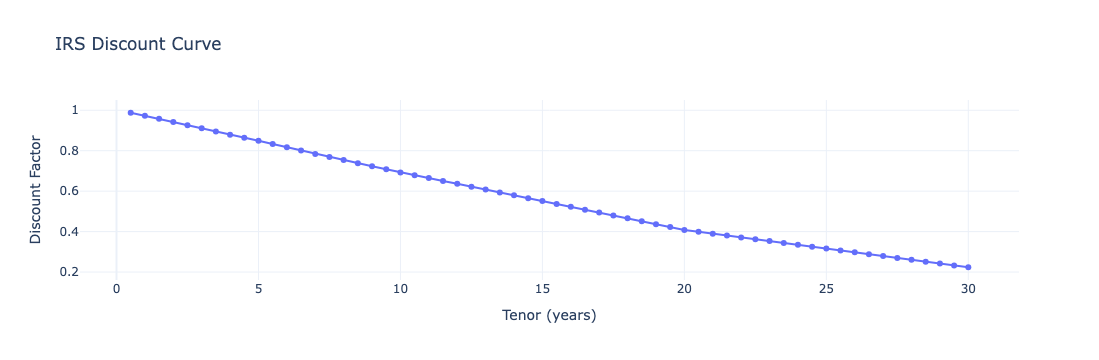

In [ ]:
plot_discount_curve(df=IRS_Interpolated_Data,
                    discount_curve="IRS_Discount_Factor",
                    title="IRS Discount Curve")

## Forward swap rates

### Forward Swap Rate Bootstrapping

This section calculates **forward swap rates** based on bootstrapped IRS discount factors.

Each forward swap rate is defined by a:
- **Start year**: when the forward swap begins.
- **Tenor**: number of years the swap lasts.
- The goal is to find the swap rate \( S \) such that the present value of floating and fixed legs match.

---

#### Equation Being Solved

The following equation is solved for each row using `scipy.optimize.brentq`:

$$
\sum_{i} DF_i \cdot DF_{i-1} \cdot 2 = (S + 2) \sum_{i} DF_i
$$

Where:
- \( DF_i \): IRS discount factor at year \( i \)
- \( S \): Forward swap rate to be solved
- The left-hand side is a weighted sum of product of adjacent discount factors.
- The right-hand side is a scaled sum of the discount factors, including the fixed leg adjustment.

---

#### Algorithm Steps

1. **Loop** over each row in the `Forward_swap_rates_df`.
2. Extract the `Start` and `Tenor` for the swap.
3. Subset the IRS curve for the forward period \((\text{Start}, \text{Start} + \text{Tenor}]\).
4. Compute the sum of $$  DF_i \cdot DF_{i-1} \cdot 2 $$
5. Solve for \( S \) such that the equation balances.
6. Store the result in `Forward_Swap_Rates`.

---

In [ ]:
Forward_swap_rates_df = pd.DataFrame({'Start' : [1]*5 + [5]*5 + [10]*5,
                                    'Tenor' : [1,2,3,5,10]*3, 
                                    'Forward_Swap_Rates': [np.nan]*15})

for i in Forward_swap_rates_df.index:
    def equation(S, 
                 start = Forward_swap_rates_df.at[i, 'Start'], 
                 tenor = Forward_swap_rates_df.at[i, 'Tenor'], 
                 irs = IRS_cleaned):
        
        irs1 = irs[(irs['Years'] > start)&(irs['Years'] <= start+tenor)].copy()
    
        sum1 = 0
        for i in irs1.index:
                sum1 += irs.at[i, 'OIS_Discount_Factor']*irs.at[i-1, 'IRS_Discount_Factor']/irs.at[i, 'IRS_Discount_Factor']*2
        
        sum2 = (S+2)*np.sum(irs1['OIS_Discount_Factor'])
        
        return sum1-sum2

    Forward_swap_rates_df.iloc[i, Forward_swap_rates_df.columns.get_loc("Forward_Swap_Rates")] = brentq(equation, 0.0001, 0.5)

In [ ]:
Forward_swap_rates_df

,Start,Tenor,Forward_Swap_Rates
0,1,1,0.031922
1,1,2,0.033217
2,1,3,0.033982
3,1,5,0.035238
4,1,10,0.038419
5,5,1,0.039274
6,5,2,0.040075
7,5,3,0.040072
8,5,5,0.041093
9,5,10,0.043634
